In [1]:
# Importing the necessary packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import dates as pltdates

In [2]:
# Importing Data ########################

# Global airline routes from OpenFlights
airlineCode, airlineID, source, sourceID, destination, destinationID, codeshare, stops, equipment = np.loadtxt("../data/routes.csv",delimiter=",",unpack=True,dtype='U',encoding='utf8')

# Airport and location data from OpenFlights
ap_city,ap_country,iata,icao = np.loadtxt("../data/airports.csv",delimiter=",",usecols=[2,3,4,5],unpack=True,dtype='U',encoding='utf8')

# List of Indian Airports
ind_airports_iata = iata[(ap_country=="India")]  # List of all Indian airports

# Removing quotation marks. (Some extra commas are causing trouble, should fix it)
ind_airports_iata = np.array([w.replace('"', '') for w in ind_airports_iata])
ap_city = np.array([w.replace('"', '') for w in ap_city])
ap_country = np.array([w.replace('"', '') for w in ap_country])
iata = np.array([w.replace('"', '') for w in iata])
icao = np.array([w.replace('"', '') for w in icao])


# Getting Country-wise Ban Data
ban_country, ban_date = np.loadtxt("../data/ban_data.csv",delimiter=",",usecols=[0,1],unpack=True,dtype='U',encoding='utf8')

# ### Today's date ###

# today = datetime.now().strftime("%Y")+now.strftime("%m")+now.strftime("%d")

# print(today)



## Collect the day-wise confirmed cases data #########

# Finding the dates over which we collect data, and the total number of columns N

with open("../data/infected_data.csv", 'rb') as f:
    line = next(f) # read 1 line
    N = len(line.split(b','))

dates = np.loadtxt("../data/infected_data.csv",delimiter=",",usecols=np.arange(1,N-1),unpack=True,dtype='int64')[:,0]
    
# List of countries for infected data
countries = np.loadtxt("../data/infected_data.csv",delimiter=",",skiprows=1,usecols=(0),unpack=True,dtype='U')
# List of infected per country as a function of time
countrywise_infected = np.loadtxt("../data/infected_data.csv",delimiter=",",skiprows=1,usecols=np.arange(1,N-1),unpack=True,dtype='U')
# Population per country and the travelling population
pop_country, pop_total, pop_urban, pop_travelling = np.loadtxt("../data/pop_data.csv",delimiter=",",usecols=(0,2,3,4),unpack=True,dtype='U')


tpc = 2 ## Choose 1: Total population ||  2: Urban population || 3: Flying population
        ## I have chosen to use urban population in the denominator


#######################################################


In [12]:
# Input Parameters #######################

ppl_per_flt = 200

q_date = [20200131,20200229,20200331]
q_prob = [0       ,0.25    ,0.50]


In [13]:
list_iap = [] # List of Indian Airports

for i in range(0,len(ind_airports_iata)):
    if(ind_airports_iata[i]!="\\N"):
        list_iap.append(ind_airports_iata[i])


# Finding Foreign Airports Feeding into each Indian Airport ###########
        
list_fap = [] # List of Foreign Airports feeding to Indian Airport i

for i in range(0,len(list_iap)):
    all_origins = source[(destination==list_iap[i])] # Find all flights to an Indian airport i
    
    temp_list=[]
    
    for o in all_origins:               # For every foreign airport to i
        if (o not in list_iap):         # If the airport isn't an Indian airport
            temp_list.append(o)         # Add it to a temporary list
    
    list_fap.append(temp_list)          # Append this list to list_fap


list_fc = []  # List of Foreign countries feeding into Indian Airport i

# Finding Foreign Countries Feeding into each Indian Airport ###########

for i in range(0,len(list_fap)):
    temp_list=[]
    for j in range(0,len(list_fap[i])):
        temp_name = ap_country[np.where(iata==list_fap[i][j])]
        if(len(temp_name)== 0):
            print("Airport with code" + list_fap[i][j] + " not found!")
        else:
            temp_list.append(temp_name[0])
    list_fc.append(temp_list)

In [14]:
# D_ij: Number of passengers flying from airport j to Indian airport i on a day t #######################################

def Dij(fcs,t):
    temp_list = []
    for j in range(0,len(fcs)):
        if(fcs[j]=="Hong Kong"):
            ctry = "China"
        elif(fcs[j]=="Yemen" or fcs[j]=="Burma"  or fcs[j]=="Turkmenistan" or fcs[j]=="Tajikistan" or fcs[j]=="Reunion"):
            ctry = "Other"
        else:
            ctry = fcs[j]
        
        ctry_ind = np.where(ban_country==ctry)
        #print(ctry)

        if(len(ctry_ind[0])==0):
            print("Country " + ctry + " not found.")
            temp_list.append("-")
        else:
            index = ctry_ind[0][0]
            #temp_list.append(ban_date[index])
            #print(int(ban_date[index]))
            
            if(int(ban_date[index])<t):
                temp_list.append(int(ppl_per_flt))
            else:
                temp_list.append(int(0))
    
    return np.array(temp_list)
##############################################################################        


# pj: Fraction of the travellers from country j that are infected ############

def pj(fcs, t):
    temp_list = []
    
    try:
        col = np.where(dates==t)[0][0]
        
        for j in range(0,len(fcs)):
            if(fcs[j]=="Hong Kong"):
                ctry = "China"
            elif(fcs[j]=="Yemen" or fcs[j]=="Burma" or fcs[j]=="Turkmenistan"or fcs[j]=="Tajikistan" or fcs[j]=="Maldives"  or fcs[j]=="Reunion"):
                ctry = "Other"
            else:
                ctry = fcs[j]
        
            try:
                
                row = np.where(countries==ctry)[0][0]
                pop_ch = []
                if(tpc == 1):
                    pop_ch = pop_total
                elif(tpc == 2):
                    pop_ch = pop_urban
                elif(tpc == 3):
                    pop_ch = pop_travelling
                else:
                    print("Invalid choice of variable tpc")
                
                total_pop_index = np.where(pop_country==ctry)[0][0]
                total_pop = float(pop_ch[total_pop_index])
                #print(total_pop)
                
                temp_list.append(float(countrywise_infected[col][row])/total_pop)
            except IndexError:
                print("Country " + ctry + " not found!")
            
    except IndexError:
        print("Date invalid!")
    
    return np.array(temp_list)
##################################################################################

### q(t): Detection probability at Indian airports on day t ######################

def q(t):
    _i = 0
    
    if(t<=q_date[_i]):
        return q_prob[0]                # Detection probability in Jan
    
    for _i in range (1,len(q_date)):
        if(q_date[_i-1]<t<=q_date[_i]):
            return q_prob[_i]             # Detection probability in Feb
            break

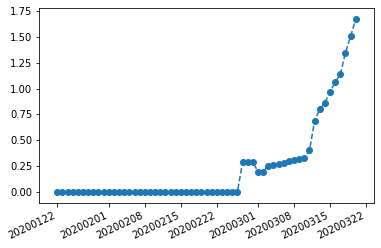

In [15]:

# Plotting out the infected that have entered the country ######################

inf_at_t = []

for t in dates:
    ans = 0.0                           # Sum over all airports i
    for i in range(0,len(list_fc)):
        if(len(list_fc[i])==0):         # If no international airports feed in, add 0 people
            ans = ans + 0
        else:
            Dijpj = np.sum(Dij(list_fc[i],t)*pj(list_fc[i],t))  # Sum all individuals from airport j
            ans = ans+Dijpj             # Sum over all Indian airports i
            
    inf_at_t.append(ans*(1-q(t)))       # Return the total number that escaped detection


    
# Format the graph to show dates on the x-axis ###################################################

datelist=[]                             # List of all dates over which we're running this simulation

for d in dates:
    datelist.append(str(d))

converted_dates = list(map(datetime.strptime, datelist, len(datelist)*['%Y%m%d']))
x_axis = converted_dates
y_axis = inf_at_t

plt.plot(x_axis,y_axis,linestyle='--')
plt.scatter(x_axis,y_axis)

ax = plt.gcf().axes[0] 
formatter = pltdates.DateFormatter('%Y%m%d')
ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=25)
#plt.savefig('../images/n_inf_at_t using flying_pop.png')
plt.show()

##################################################################################################

In [16]:
def SIR(inf,t_in,t_fin):
    
    # Input parameters ####################
    N = 1e9                      # int; Total population.
    
    I0, R0 = inf, 0             # float; float; Initial number of infected and recovered individuals
    
    S0 = N - I0 - R0            # float; Everyone else, S0, is susceptible to infection initially.
    
    beta, gamma = 2.4,1.0 # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    
    t = np.linspace(t_in, t_fin, t_fin+1-t_in)# A grid of time points (in days)
    
    #########################################

    # The SIR differential equations ########
    
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    #########################################
    
    y0 = S0, I0, R0                                   # Initial conditions vector
    
    ret = odeint(deriv, y0, t, args=(N, beta, gamma)) # Integrate the SIR equations over the time grid, t.
    
    S, I, R = ret.T                                   # Return the transpose of the matrix
    return I/N

#     plt.plot(t,S)
#     plt.plot(t,I)
#     plt.plot(t,R)

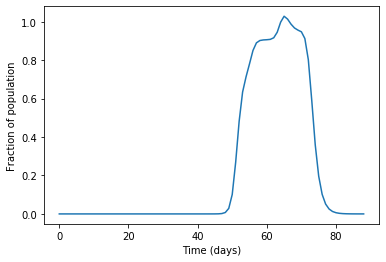

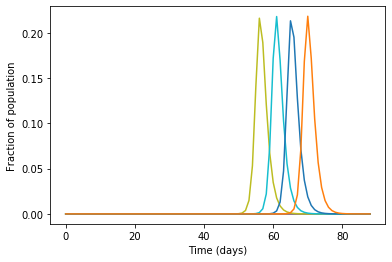

In [17]:

T =  int(1.5*len(dates))                        # Total number days over which we're looking (till present)

# 2D array to store data?

dat = np.zeros((len(dates),T+1),float)

# For every day i, run the simulation from i until day T (present) with inf_at_t[i] as 'initial' infected 

for i in range(0,len(dates)):
    I_from_t = SIR(inf_at_t[i],i,T)
    
    for j in range(i,T+1):
        dat[i][j] = I_from_t[j-i]


#print(dat)

t_plot = np.linspace(0,T,T+1)
inf_plot=np.sum(dat,axis=0)

plt.plot(t_plot,inf_plot)
plt.xlabel('Time (days)')
plt.ylabel('Fraction of population')
plt.savefig('../images/total_infected_after_T.png')
plt.show()
for i in range(0,60):
    if(i%5==0):
        plt.plot(np.linspace(0,T,T+1),dat[i,:])
plt.xlabel('Time (days)')
plt.ylabel('Fraction of population')
plt.savefig('../images/individual_infected_after_T.png')
plt.show()

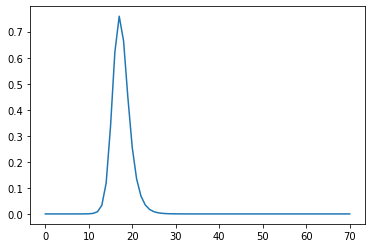

In [18]:
dates = [1,2,3,4,5]
T =  70 #len(dates)                        # Total number days over which we're looking (till present)

# 2D array to store data?

dat = np.zeros((len(dates),T+1),float)

# For every day i, run the simulation from i until day T (present) with inf_at_t[i] as 'initial' infected 

for i in range(0,len(dates)):
    I_from_t = SIR(i,i,T)
    
    for j in range(i,T+1):
        dat[i][j] = I_from_t[j-i]


#print(np.sum(dat,axis=0))

tit = np.linspace(0,T,T+1)

# print(dat)
# print()
# print("The combined number is:")
# print(np.sum(dat,axis=0))


plt.plot(tit,np.sum(dat,axis=0))

I_from_t = SIR(inf_at_t[0],0,T)

In [ ]:
fin = 200
plt.plot(np.linspace(0,fin,fin+1),SIR(10,0,fin))

In [ ]:
cntry_pop, t_pop, u_pop, a_pop = np.genfromtxt("../data/pop_data.csv",delimiter=",",usecols=[0,2,3,4],unpack=True,dtype='U')

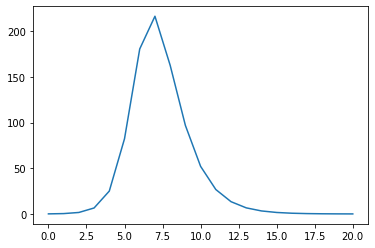

In [24]:
plt.plot(np.linspace(0,20,21),SIR(0.1,0,20))